New Belgium Beer Info
Scraped from Beer Advocate
With Python, pandas, Seaborn and Beautiful Soup
By Jeff Hale
2019-11-21

In [176]:
# Import necessary libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Display graphics
sns.set(rc={'figure.figsize':(15,10)})

# The Plan
New Belgium brewery has held a special place in my heart ever since I traveled west and had my first Fat Tire. In the wake of New Belgium's sale to a [conglomerate](https://www.marketwatch.com/story/fat-tire-brewer-new-belgium-is-latest-to-sell-in-craft-beer-buying-bonanza-2019-11-19), I was chatting with my brothers about our favorite and least favorite New Belgium brews. I thought it would be fun to see what all they had released over time and see if we agreed with Beer Advocate's ratings of the beers. 

In this Jupyter notebook I'll show you how to scrape the data, clean it, and view it. Then we'll write it to an output file and import it into Tableau for a lovely interactive dashboard. You can see the results here: [https://public.tableau.com/profile/jeff.hale6436#!/vizhome/NewBelgiumBeerRatings/NewBelgiumBeerAdvocateRatings](https://public.tableau.com/profile/jeff.hale6436#!/vizhome/NewBelgiumBeerRatings/NewBelgiumBeerAdvocateRatings).

## Scrape the data

Let's try to read the data in to pandas the easy way, first, using `pd.read_html()`. 

In [177]:
# df = pd.read_html('https://www.beeradvocate.com/beer/profile/192/')

That throws an error because we need to send a header to access the website, so let's scrape the old fashioned way - with use Requests and BeautifulSoup.

In [178]:
url = 'https://www.beeradvocate.com/beer/profile/192/'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

In [179]:
r.text[0:300]

'<!DOCTYPE html>\n<html id="XenForo" lang="en-US" dir="LTR" class="Public NoJs uix_javascriptNeedsInit LoggedOut Sidebar  Responsive pageIsLtr   not_hasTabLinks  hasSearch   is-sidebarOpen hasRightSidebar is-setWidth navStyle_0 pageStyle_0 hasFlexbox" xmlns:fb="http://www.facebook.com/2008/fbml">\n<hea'

### That looks good! 

Uncomment the sections of the next two cells if you want a whole lot of HTML to read.

In [180]:
soup = bs(r.text, 'html.parser')
# soup

In [181]:
# soup.find_all('table')

I didn't have a lot of look trying to grab the table directly, but the only `tbody` is what we want, so let's latch on to that and pull out all the row data.

In [182]:
data = []
tbody = soup.find('tbody')
rows = tbody.find_all('tr')

for row in rows:
    cells = row.find_all('td')
    data.append([content.text.strip() for content in cells])

### Let's make a pandas DataFrame out of our data.

In [183]:
df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5
0,1554,European Dark Lager,6,"4,226",3.84,-
1,1969 Lager,American Lager,4.7,15,3.41,-
2,Abbey,Belgian Dubbel,7,"2,355",4.04,-
3,Accumulation,Belgian IPA,6.2,"2,150",3.74,-
4,Atomic Pumpkin,Pumpkin Beer,6.4,2,3.46,-


### Looks like we have an extra column we can get rid of.

In [184]:
df = df.drop(5, axis='columns')
df.head()

,0,1,2,3,4
0,1554,European Dark Lager,6,"4,226",3.84
1,1969 Lager,American Lager,4.7,15,3.41
2,Abbey,Belgian Dubbel,7,"2,355",4.04
3,Accumulation,Belgian IPA,6.2,"2,150",3.74
4,Atomic Pumpkin,Pumpkin Beer,6.4,2,3.46


### Let's get some names on those columns.

In [185]:
df.columns=['Name', 'Style', 'ABV', 'Ratings', 'Avg' ]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 5 columns):
Name       53 non-null object
Style      53 non-null object
ABV        53 non-null object
Ratings    53 non-null object
Avg        53 non-null object
dtypes: object(5)
memory usage: 2.2+ KB


### Let's add a column showing this is currently sold beer.

In [186]:
df['Current'] = 'Yes'

### Let's get rid of the commas in the `Ratings` column.

In [187]:
df['Ratings'] = df.loc[:,'Ratings'].str.replace(',', '')
df.head()

,Name,Style,ABV,Ratings,Avg,Current
0,1554,European Dark Lager,6,4226,3.84,Yes
1,1969 Lager,American Lager,4.7,15,3.41,Yes
2,Abbey,Belgian Dubbel,7,2355,4.04,Yes
3,Accumulation,Belgian IPA,6.2,2150,3.74,Yes
4,Atomic Pumpkin,Pumpkin Beer,6.4,2,3.46,Yes


### Let's make all the columns numeric.

In [188]:
df['ABV'] = pd.to_numeric(df['ABV'])
df['Ratings'] = pd.to_numeric(df['Ratings'])
df['Avg'] = pd.to_numeric(df['Avg'])
df.head()

,Name,Style,ABV,Ratings,Avg,Current
0,1554,European Dark Lager,6.0,4226,3.84,Yes
1,1969 Lager,American Lager,4.7,15,3.41,Yes
2,Abbey,Belgian Dubbel,7.0,2355,4.04,Yes
3,Accumulation,Belgian IPA,6.2,2150,3.74,Yes
4,Atomic Pumpkin,Pumpkin Beer,6.4,2,3.46,Yes


In [189]:
df.describe()

,ABV,Ratings,Avg
count,53.000000,53.000000,53.000000
mean,6.496226,680.433962,3.656415
std,1.544838,1572.200632,0.781773
min,3.400000,0.000000,0.000000
25%,5.200000,2.000000,3.540000
50%,6.400000,21.000000,3.810000
75%,7.500000,385.000000,4.000000
max,10.000000,9150.000000,4.320000


### Let's see how a quick bar chart looks.

I set the size in the first code cell at the start of the Notebook.

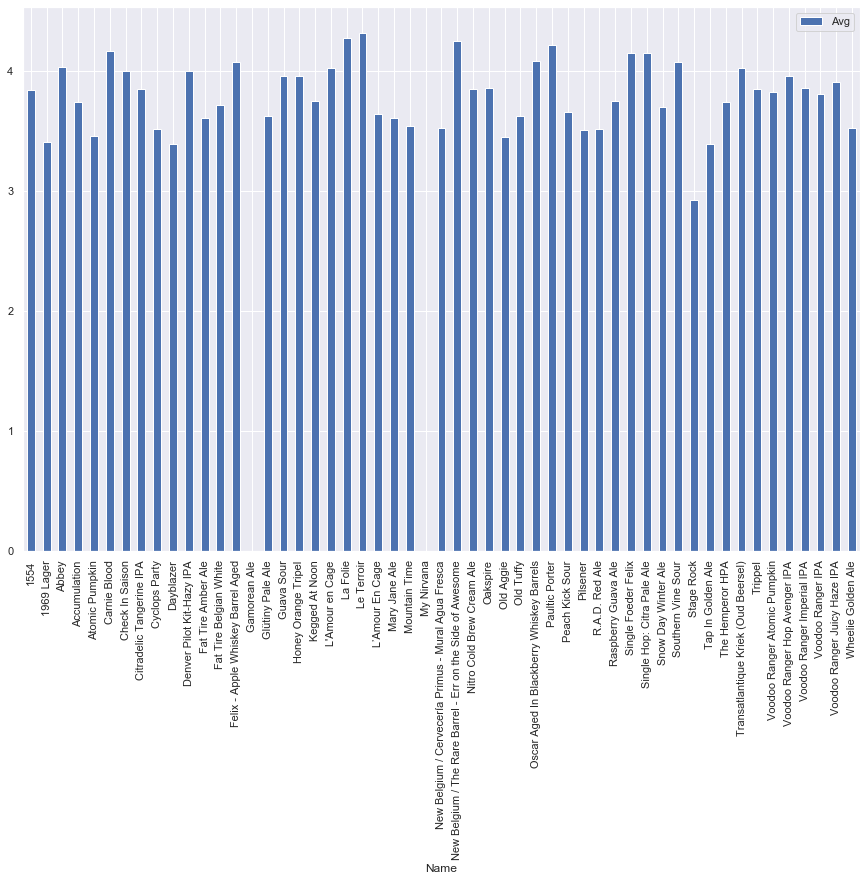

In [190]:
df.plot.bar('Name', 'Avg')

### Let's make this prettier with Seaborn. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]), <a list of 53 Text xticklabel objects>)

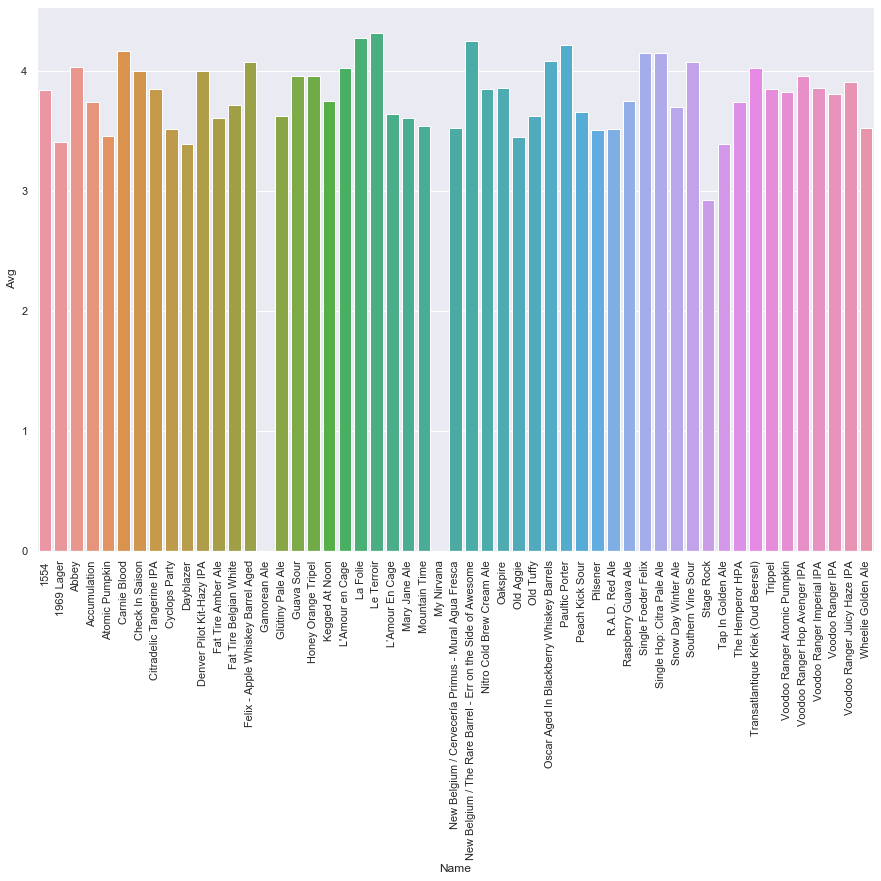

In [191]:
sns.barplot(df['Name'], df['Avg'])
plt.xticks(rotation=90)

### Let's filter so we only keep beers with at least 300 reviews.

In [192]:
df_smaller = df[df['Ratings']>=300].reset_index(drop=True)
df_smaller

,Name,Style,ABV,Ratings,Avg,Current
0,1554,European Dark Lager,6.0,4226,3.84,Yes
1,Abbey,Belgian Dubbel,7.0,2355,4.04,Yes
2,Accumulation,Belgian IPA,6.2,2150,3.74,Yes
3,Citradelic Tangerine IPA,American IPA,6.0,1898,3.85,Yes
4,Dayblazer,American Cream Ale,4.8,348,3.39,Yes
5,Fat Tire Amber Ale,American Amber / Red Ale,5.2,9150,3.61,Yes
6,Fat Tire Belgian White,Belgian Witbier,5.2,385,3.72,Yes
7,La Folie,Flanders Oud Bruin,7.0,4043,4.28,Yes
8,Le Terroir,American Wild Ale,7.5,2456,4.32,Yes
9,Snow Day Winter Ale,American Black Ale,6.2,1526,3.70,Yes


### Let's sort by the average rating.

In [193]:
df_ss = df_smaller.sort_values(by='Avg', ascending=False).reset_index(drop=True)
df_ss

,Name,Style,ABV,Ratings,Avg,Current
0,Le Terroir,American Wild Ale,7.5,2456,4.32,Yes
1,La Folie,Flanders Oud Bruin,7.0,4043,4.28,Yes
2,Abbey,Belgian Dubbel,7.0,2355,4.04,Yes
3,Voodoo Ranger Juicy Haze IPA,New England IPA,7.5,685,3.91,Yes
4,Voodoo Ranger Imperial IPA,American Imperial IPA,9.0,665,3.86,Yes
5,Citradelic Tangerine IPA,American IPA,6.0,1898,3.85,Yes
6,Trippel,Belgian Tripel,8.5,3203,3.85,Yes
7,1554,European Dark Lager,6.0,4226,3.84,Yes
8,Voodoo Ranger Atomic Pumpkin,Pumpkin Beer,6.4,328,3.83,Yes
9,Voodoo Ranger IPA,American IPA,7.0,1066,3.81,Yes


## Let's make a horizontal bar chart in Seaborn showing the average rating.

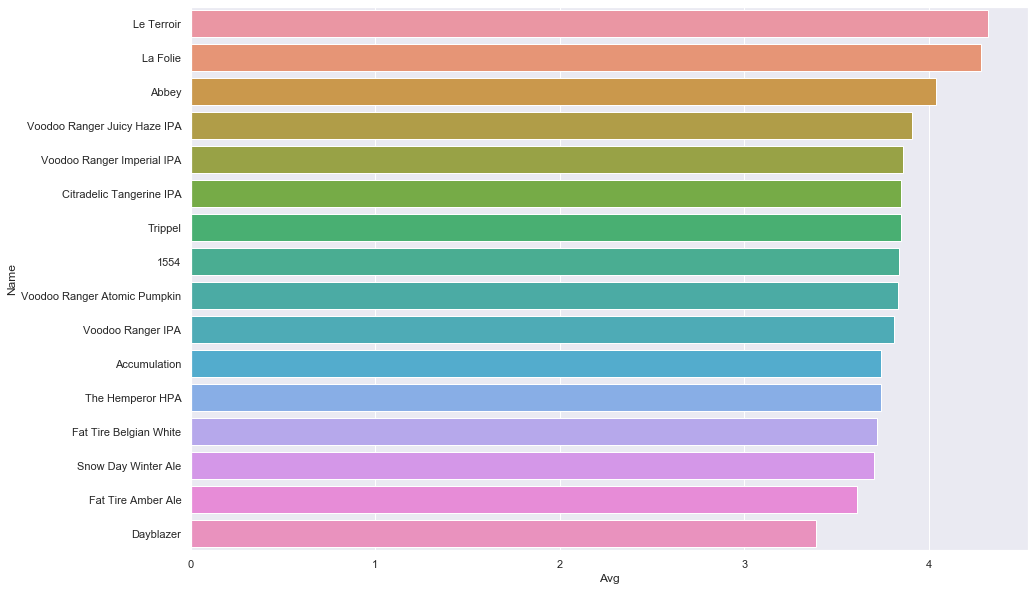

In [194]:
sns.barplot(x='Avg', y='Name', data=df_ss)

# This doesn't include all New Belgium beers, we need to scrape the archives!

This will require scraping another page, putting them in a DataFrame and concatenating the DataFrames.

In [195]:
url = ('https://www.beeradvocate.com/beer/profile/192/?view=beers&show=arc')
header= {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

In [196]:
r.text[:500]

'<!DOCTYPE html>\n<html id="XenForo" lang="en-US" dir="LTR" class="Public NoJs uix_javascriptNeedsInit LoggedOut Sidebar  Responsive pageIsLtr   not_hasTabLinks  hasSearch   is-sidebarOpen hasRightSidebar is-setWidth navStyle_0 pageStyle_0 hasFlexbox" xmlns:fb="http://www.facebook.com/2008/fbml">\n<head>\n<meta charset="utf-8" />\n<meta http-equiv="X-UA-Compatible" content="IE=Edge,chrome=1" />\n<meta name="viewport" content="width=device-width, initial-scale=1" />\n<base href="https://www.beeradvocate'

In [197]:
soup = bs(r.text)
#soup

In [198]:
data = []
tbody = soup.find('tbody')

rows = tbody.find_all('tr')

for row in rows:
    cells = row.find_all('td')
    data.append([content.text.strip() for content in cells])

### Let's make the same improvements to the old sales DataFrame that we did to the current sales one. 

If we had to do this anymore I'd make this into a reusable function, but we don't, so I won't.

In [199]:
df_old = pd.DataFrame(data)
df_old = df_old.drop(5,axis=1)
df_old.columns=['Name', 'Style', 'ABV', 'Ratings', 'Avg' ]
df_old['Current'] = 'No'
df_old

,Name,Style,ABV,Ratings,Avg,Current
0,1554 With Chinook Hops,Belgian Dark Ale,0,2,3.63,No
1,25th Anniversary Ale,American Pale Ale (APA),5.7,4,3.83,No
2,2° Below Winter Ale,English Extra Special / Strong Bitter (ESB),6.6,"1,227",3.65,No
3,A.J. Winter Ale,Belgian Strong Dark Ale,0,2,3.61,No
4,Abruzzi Rye Porter,Rye Beer,6.8,3,3.7,No
...,...,...,...,...,...,...
295,Whiskey Fat Back (Leopold BA Fat Tire),American Amber / Red Ale,6,3,4.3,No
296,Whizbang Hoppy Blonde Ale,American Blonde Ale,5.7,175,3.78,No
297,Wood Aged Sour Stout,American Stout,8.5,1,3.52,No
298,Wood Cellar Reserve Passionfruit Foeder Saison,American Wild Ale,0,0,0,No


In [200]:
df_old['Ratings'] = df_old.loc[:,'Ratings'].str.replace(',', '')
df_old['ABV'] = pd.to_numeric(df_old['ABV'])
df_old['Ratings'] = pd.to_numeric(df_old['Ratings'])
df_old['Avg'] = pd.to_numeric(df_old['Avg'])

In [201]:
df_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
Name       300 non-null object
Style      300 non-null object
ABV        300 non-null float64
Ratings    300 non-null int64
Avg        300 non-null float64
Current    300 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 14.2+ KB


Looks good. Now let's filter out everything with less than 100 reviews.

In [202]:
df_os = df_old[df_old['Ratings']>=300].sort_values(by='Avg', ascending=False).reset_index(drop=True)
df_os

,Name,Style,ABV,Ratings,Avg,Current
0,Lips Of Faith - Super India Pale Ale (Alpine C...,American Imperial IPA,9.0,801,4.25,No
1,Eric's Ale,American Wild Ale,7.0,700,4.10,No
2,Cocoa Molé,Chile Beer,9.0,1024,4.03,No
3,Lips Of Faith - Fresh Hop India Pale Ale,American IPA,7.0,328,4.02,No
4,Grand Cru Abbey Ale,Belgian Strong Dark Ale,9.5,334,4.01,No
...,...,...,...,...,...,...
56,Lips Of Faith - Yuzu Imperial Berliner Weisse,Berliner Weisse,8.0,496,3.43,No
57,Rolle Bolle,Fruit and Field Beer,5.5,712,3.39,No
58,Lips Of Faith - Brett Beer,American Brett,7.5,529,3.34,No
59,Lips Of Faith - Pluot,Belgian Tripel,10.0,380,3.33,No


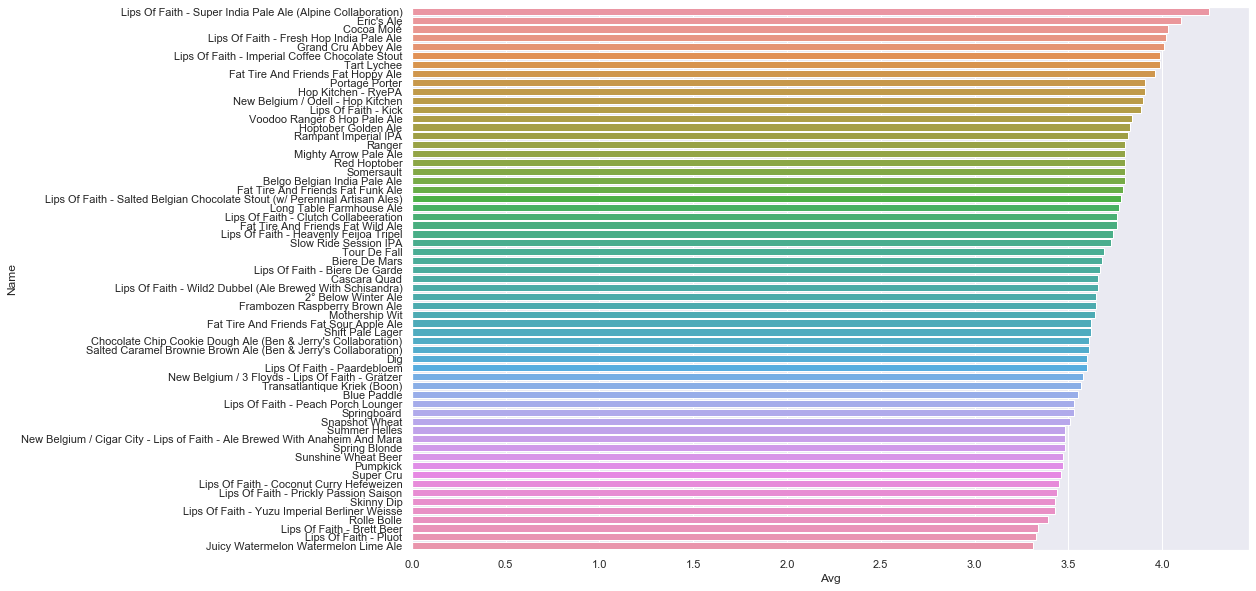

In [203]:
sns.barplot(x='Avg', y='Name', data=df_os)

That's pretty.

### Let's combine the two DataFrames.

In [204]:
df_combo = pd.concat([df_ss, df_os]).reset_index(drop=True)
df_combo

,Name,Style,ABV,Ratings,Avg,Current
0,Le Terroir,American Wild Ale,7.5,2456,4.32,Yes
1,La Folie,Flanders Oud Bruin,7.0,4043,4.28,Yes
2,Abbey,Belgian Dubbel,7.0,2355,4.04,Yes
3,Voodoo Ranger Juicy Haze IPA,New England IPA,7.5,685,3.91,Yes
4,Voodoo Ranger Imperial IPA,American Imperial IPA,9.0,665,3.86,Yes
...,...,...,...,...,...,...
72,Lips Of Faith - Yuzu Imperial Berliner Weisse,Berliner Weisse,8.0,496,3.43,No
73,Rolle Bolle,Fruit and Field Beer,5.5,712,3.39,No
74,Lips Of Faith - Brett Beer,American Brett,7.5,529,3.34,No
75,Lips Of Faith - Pluot,Belgian Tripel,10.0,380,3.33,No


### Let's write the combined DataFrame out to a `.csv` file so we can play with it in Tableau.

In [205]:
df_combo.to_csv('New_Belgium_over_300_reviews_nov.')

And here's the finished product in Tableau that you can play with: [https://public.tableau.com/profile/jeff.hale6436#!/vizhome/NewBelgiumBeerRatings/NewBelgiumBeerAdvocateRatings](https://public.tableau.com/profile/jeff.hale6436#!/vizhome/NewBelgiumBeerRatings/NewBelgiumBeerAdvocateRatings)

## Wrap

In this article, you saw how to use requests and BeatifulSoup to scrape a website. You saw how to use pandas to inspect and manipulate the data. You saw how to use Matplotlib and Seaborn to display the data. Finally, you saw how to concatenate the DataFrames and output a `.csv` file. Then I quickly imported the `.csv` into Tableau, made a worksheet and a dashboard, and exported it to Tableau Public's server for everyone to use.

### Thanks for reading! I hope you found this exercise useful. 

## If you're into things like data science, Docker, and Python check out my articles at [Medium](https://medium.com/@jeffhale) and my books at [Memorable Tech](https://memorabletech.com). And follow me for more fun data stuff!
